# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment.

In [1]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from IPython.display import display

seed = 2023
np.random.seed(seed)


## Question 1: /20 pts


Customer Lifetime Value (CLV) is the total income a business can expect from a customer over the entire period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth. We want to predict CLV for an auto insurance company.

1. Read in the `Vehicle_Insurance.csv` dataset and display the last 5 rows.
2. Conduct the required data preparation.

### 1.1 Read the dataset and display the last 5 rows

In [2]:
df = pd.read_csv("Vehicle_Insurance.csv")
df.tail()


,clv,Coverage,Gender,Income,Marital.Status,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Renew.Offer.Type,Total.Claim.Amount,Vehicle.Class
8625,4100.398533,Premium,F,47761,Single,104,0,1,Offer1,541.282007,Four-Door Car
8626,3096.511217,Extended,F,21604,Divorced,79,0,1,Offer1,379.200000,Four-Door Car
8627,8163.890428,Extended,M,0,Single,85,3,2,Offer1,790.784983,Four-Door Car
8628,7524.442436,Extended,M,21941,Married,96,0,3,Offer3,691.200000,Four-Door Car
8629,2611.836866,Extended,M,0,Single,77,0,1,Offer4,369.600000,Two-Door Car


### 1.2 Remove the rows with "clv" $> 16000$ as well as those with "clv" $< 2200$ from the dataset. What's the shape of the dataframe now?

In [3]:
df = df[(df["clv"] <= 16000) & (df["clv"] >= 2200)]  # remove outliers
print("Dataframe shape is now", df.shape)


Dataframe shape is now (8212, 11)


### 1.3 Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 3 rows.

In [4]:
categorical_features = [
    "Coverage",
    "Gender",
    "Marital.Status",
    "Renew.Offer.Type",
    "Vehicle.Class",
]

encoder = preprocessing.OneHotEncoder(drop="first", sparse_output=False)

encoded_data = encoder.fit_transform(df[categorical_features])

encoded_df = pd.DataFrame(
    encoded_data, columns=encoder.get_feature_names_out(categorical_features)
)

other_cols = df.drop(columns=categorical_features)

df = pd.concat(
    [other_cols.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1
)

df.head(3)


,clv,Income,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Coverage_Extended,Coverage_Premium,Gender_M,Marital.Status_Married,Marital.Status_Single,Renew.Offer.Type_Offer2,Renew.Offer.Type_Offer3,Renew.Offer.Type_Offer4,Vehicle.Class_Luxury Car,Vehicle.Class_Luxury SUV,Vehicle.Class_SUV,Vehicle.Class_Sports Car,Vehicle.Class_Two-Door Car
0,2763.519279,56274,69,0,1,384.811147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6979.535903,0,94,0,8,1131.464935,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12887.431650,48767,108,0,2,566.472247,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 1.4 Use `pandas.DataFrame.apply` to apply square root transformation to "Total.Claim.Amount" and log to the target variable. And then, create your `X` and `y`. (No training/test splitting yet) 

In [5]:
df["Total.Claim.Amount"] = df["Total.Claim.Amount"].apply(np.sqrt)
df["clv"] = df["clv"].apply(np.log)

X = df.drop("clv", axis=1)
y = df["clv"]


### 1.5 Build a new design matrix by applying polynomial expansion on the `X` from Question 1.4.

Hint: Specify degree=2 and do NOT include the column with power 0 (i.e., the column with all elements being 1)

In [6]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())


### 1.6 Standardize your design matrix (from Question 1.5) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
X_scaled_df = pd.DataFrame(X_scaled, columns=poly.get_feature_names_out())


### 1.7 What is the shape of the resultant DataFrame obtained from question 1.6?

In [8]:
X_scaled_df.shape


(8212, 189)

## Question 2: /7 pts

Split the data into training and test sets. Hold out 30% of observations as the test set.  Pass `random_state=seed` to `train_test_split` to ensure you get the same sets per run. The design matrix to pass in to the splitter function is the dataframe whcih you got in Question 1.6. As for the target, you have created it in Question 1.4.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=seed
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

print(round(y_train.mean(), 2))


Training set shape: (5748, 189) (5748,)
Test set shape: (2464, 189) (2464,)
8.62


How many observations in your traning data set? What is the average value of the target variable in the traning data set (keep 2 decimal place)?

**YOUR ANSWER HERE:** [2pts]

Observations in training data set is 5748. Average value of target variable in training dataset is 8.62.

## Question 3: /23 pts

### 3.1 Create a SciKit Learn `Ridge` regression object. Using this object, run a ridge regression analysis of the target variable against all the transformed predictor variables using your training data. Include the arguement `alpha=4.0`. In addition, the ridge regression should be fitted with the intercept.

In [10]:
# ridge regression
ridge_reg = skl.Ridge(alpha=4.0, fit_intercept=True)

# fit the model to the training data
ridge_reg.fit(X_train, y_train)

print("First few coefficients of the Ridge regression model:", ridge_reg.coef_[:3])


First few coefficients of the Ridge regression model: [0.0300729  0.28254497 0.02619518]


### 3.2 Vary the ridge coeficient `alpha` according to the hint. Use `cross_val_score()` to select the best `alpha` based on 'mean_squared_error'. Include the argument `cv=5`. Report the `alpha` that yields the smallest mean_squared_error.   

In [11]:
# Define a range of alpha values to explore
alphas = np.logspace(-4, 4, 50)

# Initialize variables to store the best score and corresponding alpha
best_score = np.inf
best_alpha = None

# Loop through each alpha, perform cross-validation, and track the best score
for alpha in alphas:
    # Initialize Ridge regression with current alpha
    ridge = skl.Ridge(alpha=alpha, fit_intercept=True)

    # Perform cross-validation and calculate mean score (MSE)
    scores = cross_val_score(
        ridge, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1
    )
    mean_score = -np.mean(scores)  # Convert from negative MSE to positive

    # Update best score and alpha if current model is better
    if mean_score < best_score:
        best_score = mean_score
        best_alpha = alpha

# Report the best alpha found
print(f"Best alpha: {best_alpha} with smallest mean squared error: {best_score}")


Best alpha: 1.7575106248547894 with smallest mean squared error: 0.11146776456986222


### 3.3 Re-fit the ridge regression with `alpha` being the value obtained in the previous question. `Print` the first 3 parameters of your model.

In [12]:
# Re-fit the Ridge regression with the best alpha value
ridge_best = skl.Ridge(alpha=best_alpha, fit_intercept=True)
ridge_best.fit(X_train, y_train)

# Print the first 3 coefficients of the model
print("First 3 coefficients of the Ridge regression model:", ridge_best.coef_[:3])


First 3 coefficients of the Ridge regression model: [0.02879988 0.3263752  0.02760692]


### 3.4 Fit the linear regression without any penalty, and the regression should be fitted with the intercept. `Print` the first 3 parameters of your model.

In [13]:
lin_reg = skl.LinearRegression(fit_intercept=True)

lin_reg.fit(X_train, y_train)

print("First 3 coefficients of the linear regression model:", lin_reg.coef_[:3])


First 3 coefficients of the linear regression model: [0.01836491 0.78033996 0.03234569]


Comparing the parameters that you obtain in questions 3.3 and 3.4, what do you find?

**YOUR ANSWER HERE:** [2pts]

Comparing the first three coefficients of Ridge and Linear regression models reveals the influence of regularization on model parameters. Specifically, Ridge regression coefficients are generally smaller, showcasing the model's capacity to reduce overfitting by penalizing large coefficients, thus leading to a potentially better generalization on unseen data. This regularization effect, inherent to Ridge regression, is evident in the substantial reduction of the magnitude of coefficients compared to those from the Linear regression, which lacks such a penalty. The difference in coefficients highlights the trade-off between bias and variance, with Ridge regression introducing bias to achieve lower variance and improve model robustness, especially in cases of multicollinearity among predictors. This comparison underscores the importance of regularization in managing model complexity and enhancing predictive performance.


### 3.5 Use your trained model from Question 3.4 to predict over the test set and `print` the first 5 prediction values.

In [14]:
linear_reg_predictions = lin_reg.predict(X_test)

print("First 5 prediction values:", linear_reg_predictions[:5])


First 5 prediction values: [9.20993801 8.31670653 8.93438231 8.10039793 8.47287746]


## Question 4: /25 pts

### 4.1 Consider to fit a Lasso regression to the train dataset. Use `lasso_path()` to show the full path of the first 20 coefficients of the Lasso regression. Include the arguement `eps=8e-3` and `n_alphas=50`.

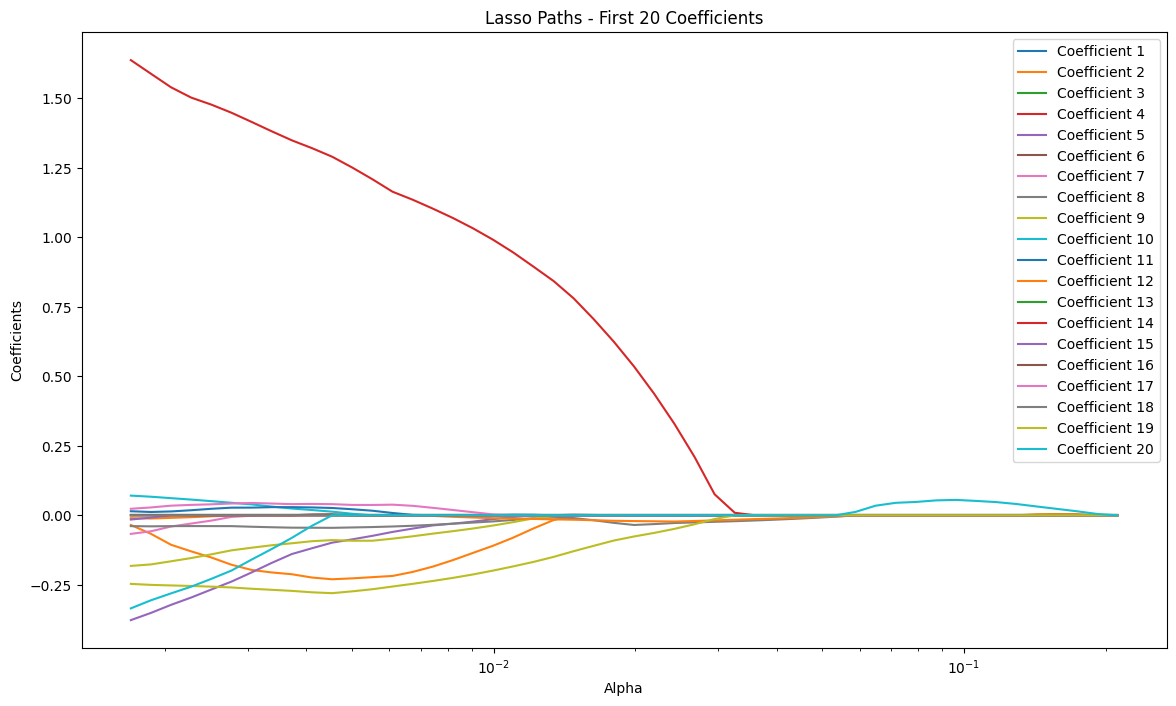

In [15]:
# Compute the Lasso path
alphas, coefs, _ = skl.lasso_path(X_train, y_train, eps=8e-3, n_alphas=50)

# Plotting the Lasso paths for the first 20 coefficients
plt.figure(figsize=(14, 8))
for i in range(20):  # Limit to the first 20 coefficients
    plt.plot(alphas, coefs[i], label=f"Coefficient {i+1}")

plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.title("Lasso Paths - First 20 Coefficients")
plt.legend()
plt.xscale("log")  # Alpha values are better represented on a log scale
plt.axis("tight")
plt.show()


Describe the trend that shows in your figure.

**YOUR ANSWER HERE:** [3pts]

The figure displays the lasso path for the first 20 coefficients of a Lasso regression model, showing how each coefficient's value changes with different levels of regularization strength (alpha). As alpha decreases (moving left on the x-axis), the regularization becomes weaker, allowing the coefficients to move away from zero and reach their least absolute shrinkage value. Most of the coefficients are quickly shrunk towards zero as alpha increases, which is consistent with Lasso's characteristic of producing sparse solutions. One coefficient, in particular, starts at a high value and decreases steadily as alpha grows, suggesting it has a strong initial relationship with the target variable that diminishes under regularization. The graph overall demonstrates Lasso's ability to perform feature selection, identifying a smaller subset of features that have the most predictive power by driving the other coefficients to zero.


### 4.2 Use the Scikit Learn's cross-validated LASSO to automatically search for the best tuning parameter of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameter and the number of the non-zero coefficients in the model.

In [16]:
# Define the cross-validated Lasso using the LassoCV class
lasso_cv = LassoCV(
    eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, fit_intercept=True
)

# Fit the LassoCV to the training data
lasso_cv.fit(X_train, y_train)

# Retrieve the best alpha value (the tuning parameter)
best_alpha_lasso = lasso_cv.alpha_

# Count the number of non-zero coefficients in the model
non_zero_coefs_lasso = np.sum(lasso_cv.coef_ != 0)

best_alpha_lasso, non_zero_coefs_lasso


(0.0019347932826026494, 92)

### 4.3 Use the Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the Elasticnet regression with intercept on the training data set. Include the same argument as question 4.2 as well as `l1_ratio=[.7, .9, .95, .99,1]`. Report the best tuning parameters.

In [17]:
# Define the cross-validated ElasticNet
elastic_net_cv = skl.ElasticNetCV(
    l1_ratio=[0.7, 0.9, 0.95, 0.99, 1],
    eps=8e-3,
    n_alphas=30,
    tol=0.001,
    cv=5,
    random_state=seed,
    fit_intercept=True,
    n_jobs=-1,
)

# Fit the ElasticNetCV to the training data
elastic_net_cv.fit(X_train, y_train)

# Retrieve the best alpha value and l1_ratio (the tuning parameters)
best_alpha_enet = elastic_net_cv.alpha_
best_l1_ratio_enet = elastic_net_cv.l1_ratio_

(best_alpha_enet, best_l1_ratio_enet)


(0.0019347932826026494, 1.0)

From the obtained tuning parameters, is the Elasticnet regression model equivalent to the Lasso regression? Briefly describe the reason. 

**YOUR ANSWER HERE:** [3pts]

From the obtained tuning parameters, the ElasticNet regression model is equivalent to the Lasso regression. Both models have selected the same alpha value of 0.0019347932826026494, which determines the strength of regularization. Crucially, the ElasticNet model has an l1_ratio of 1.0, indicating that it uses a pure L1 penalty, which is the defining characteristic of Lasso regression. The l1_ratio in ElasticNet controls the mix between L1 and L2 regularization, with 1.0 signifying all L1 and no L2 penalty. Therefore, since the l1_ratio is 1.0, the ElasticNet model simplifies to a Lasso model, both in terms of penalty applied and the strength of regularization, hence they are equivalent.


## Question 5: /16 pts

### 5.1 Start from the regression model in question 3.4, use `SequentialFeatureSelector()` to conduct the forward selection for the features of the regression model. Include the argument `n_features_to_select=20`. Report the indices of the selected features. 

FYI: Running this using 8 physical cores took about 1 minute for me.

In [18]:
# Define the Sequential Feature Selector
sfs = SequentialFeatureSelector(
    lin_reg, n_features_to_select=20, direction="forward", n_jobs=-1
)

# Fit the Sequential Feature Selector to the training data
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = sfs.get_support(indices=True)
selected_features


array([  1,   3,  12,  18,  19,  20,  28,  36,  38,  55,  59,  69,  75,
       104, 117, 118, 119, 126, 131, 143])

What do you need to change about the argument in your model if you want to conduct a backward selection?

**YOUR ANSWER HERE:** [2pts] 

To conduct backward selection instead of forward selection, you will need to change the direction argument in your SequentialFeatureSelector from "forward" to "backward". This will modify the feature selection process to start with all features and iteratively remove features until the desired number is reached, rather than starting with none and adding them.


### 5.2 Re-fit the regular linear regression based on the traning set by using the selected features from the question 5.1. Report the first 3 parameters of your model as indicated with the print function.

In [19]:
# Define the Linear Regression model to use with the selected features
lin_reg_selected = skl.LinearRegression()

# Fit the model to the training data using the selected features
lin_reg_selected.fit(X_train.iloc[:, selected_features], y_train)

# Print the first 3 parameters of the model
print("First 3 coefficients of the fitted model:", lin_reg_selected.coef_[:3])


First 3 coefficients of the fitted model: [ 0.48181157  1.07122953 -0.0122778 ]


## Question 6: /9 pts

### 6.1 Make predictions on the test set using your models in questions 3.3, 4.2, 4.3, and 5.2, respectively. Together with the predicted values obtained in question 3.5, report the first 5 rows of predicted values obtained from different models in a single DataFrame.

In [20]:
# 3.3 - ridge_best
ridge_predictions = ridge_best.predict(X_test)

# 4.2 - lasso_cv
lasso_predictions = lasso_cv.predict(X_test)

# 4.3 - elastic_net_cv
elastic_net_predictions = elastic_net_cv.predict(X_test)

# 5.2 - lin_reg_selected
lin_reg_selected_predictions = lin_reg_selected.predict(
    X_test.iloc[:, selected_features]
)

predictions_df = pd.DataFrame(
    {
        "Ridge": ridge_predictions,
        "Lasso": lasso_predictions,
        "ElasticNet": elastic_net_predictions,
        "Linear Regression (Selected Features)": lin_reg_selected_predictions,
        "Linear Regression": linear_reg_predictions,
    },
    index=range(len(ridge_predictions)),
)  # Using the length of one set of predictions to set the index

# Display the first 5 rows of the DataFrame
predictions_df.head(5)


,Ridge,Lasso,ElasticNet,Linear Regression (Selected Features),Linear Regression
0,9.244399,9.142903,9.142903,9.197035,9.209938
1,8.317396,8.303288,8.303288,8.300987,8.316707
2,8.894111,8.859596,8.859596,8.910826,8.934382
3,8.083636,8.085032,8.085032,8.025311,8.100398
4,8.432581,8.416404,8.416404,8.445480,8.472877


### 6.2 Use `mean_squared_error()` to assess the performance of different models based on all the predicted values mentioned in Question 6.1.  

In [21]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for each model
mse_ridge = mean_squared_error(y_test, ridge_predictions)
mse_lasso = mean_squared_error(y_test, lasso_predictions)
mse_elastic_net = mean_squared_error(y_test, elastic_net_predictions)
mse_lin_reg_selected = mean_squared_error(y_test, lin_reg_selected_predictions)
mse_linear_reg = mean_squared_error(y_test, linear_reg_predictions)

# Print MSE for each model rounded to 5 decimal places
print(f"MSE for Ridge Regression: {round(mse_ridge, 5)}")
print(f"MSE for Lasso Regression: {round(mse_lasso, 5)}")
print(f"MSE for ElasticNet Regression: {round(mse_elastic_net, 5)}")
print(
    f"MSE for Linear Regression (Selected Features): {round(mse_lin_reg_selected, 5)}"
)
print(f"MSE for Linear Regression: {round(mse_linear_reg, 5)}")


MSE for Ridge Regression: 0.11014
MSE for Lasso Regression: 0.10993
MSE for ElasticNet Regression: 0.10993
MSE for Linear Regression (Selected Features): 0.11077
MSE for Linear Regression: 0.11104


Which model yields the smallest mean squared error on the test dataset?

**YOUR ANSWER HERE:** [2pts]

The Lasso Regression and ElasticNet Regression models both yield the smallest mean squared error (MSE) on the test dataset, indicating the best performance among the evaluated models. With identical MSE values of 0.10993, these models outperform Ridge Regression, Linear Regression, and Linear Regression with selected features in terms of prediction accuracy. This suggests that the regularization approach of Lasso and ElasticNet, which combines L1 and L2 penalties, is particularly effective for this dataset.
